In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if False:
  %cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/
if False:
  %cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if True:
  # %cd "/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv"
  %cd "/content/drive/MyDrive/ml-project-2-roadmen-bruv"

/content/drive/.shortcut-targets-by-id/1Otvsxl8-1dcvf92GQ9nybOqsg4Z_dpEJ/ml-project-2-roadmen-bruv


## Libraries

In [3]:
from IPython.display import clear_output
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations
!pip install bayesian-optimization

clear_output()

In [4]:
import sys
sys.path.append("./utils")
sys.path.append("./helpers")

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from mask_to_submission import masks_to_submission
import utils.data_augmentation as data
from save_training_results import save_results

# For alternative loss
import torch.nn as nn
import segmentation_models_pytorch.utils.base as base
import segmentation_models_pytorch.utils.functional as F
from segmentation_models_pytorch.base.modules import Activation

# 1st network

## Control board

In [23]:

PARAMS = {
  'MODELS' : ["Unet"], # Available : "Unet","DeepLabV3","FPN", "UnetPlusPlus"
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 1,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : False, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}


In [24]:

# Default parameters for various parts
foreground_threshold = 0.5  # Threshold for determining foreground vs background
lr = 1e-4

# Loss and metric type
loss_type = "tversky" # Possible: ["dice", "tversky", "custom"]
metric_type = "custom" # custom: ["custom", "fscore"]

#For custom, changes balance between pixel and patch
patch_size = 16
w_pix = 0
w_patch = 1

In [25]:
#Creates the necessary folders for saving results
model_weights_folder = './submissions/models/'
os.makedirs(model_weights_folder, exist_ok=True)
RUN_NAME = "vic7_bo_vaug"
SUBMISSION_NAME = "submission_" + RUN_NAME + "/"
submission_folder = './submissions/' + SUBMISSION_NAME
os.makedirs(submission_folder, exist_ok=True)

# 0) Data aug

In [26]:
create_aug_data_dieg = False
create_aug_data_vic = False

if create_aug_data_dieg:
    # Create folders for data augmentation
    %mkdir data/data_train_augmented
    %mkdir data/data_train_augmented/images/
    %mkdir data/data_train_augmented/masks/
    %mkdir data/data_train_augmented/raw/
    %mkdir data/data_train_augmented/raw/images/
    %mkdir data/data_train_augmented/raw/masks/
    %mkdir data/data_validation
    %mkdir data/data_validation/images/
    %mkdir data/data_validation/masks/
    %mkdir data/data_validation/raw/
    %mkdir data/data_validation/raw/images/
    %mkdir data/data_validation/raw/masks/

    # Load images and masks from dataset
    PATH_IMG_TRAIN = "./data/training/images/"
    PATH_MASK_TRAIN = "./data/training/groundtruth/"
    img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
    key_list = list(img_train.keys())
    key_list.sort()
    # Split the images for training/validation (+ store)
    training_ratio = 0.8
    seed = 1
    train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)
    PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
    PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
    PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
    PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
    store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
    store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
    store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
    store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)
    MASK_THRESHOLD = 120
    SIZE_X = 416 #divisible by 32
    SIZE_Y = 416 #divisible by 32
    PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
    PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
    PATH_VAL_IMG = "./data/data_validation/images/"
    PATH_VAL_MASK = "./data/data_validation/masks/"
    # Load validation images and resize
    img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
    keys_val = list(img_val_raw.keys())
    resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)
    # Load training images, resize and augment using geometric transformation (+ store)
    img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
    keys_tr = list(img_tr_raw.keys())
    resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

if create_aug_data_vic:
    # Create folders for data augmentation
    %mkdir data/data_train_augmented_vic3
    %mkdir data/data_train_augmented_vic3/images/
    %mkdir data/data_train_augmented_vic3/masks/
    %mkdir data/data_train_augmented_vic3/raw/
    %mkdir data/data_train_augmented_vic3/raw/images/
    %mkdir data/data_train_augmented_vic3/raw/masks/
    %mkdir data/data_validation_vic3
    %mkdir data/data_validation_vic3/images/
    %mkdir data/data_validation_vic3/masks/
    %mkdir data/data_validation_vic3/raw/
    %mkdir data/data_validation_vic3/raw/images/
    %mkdir data/data_validation_vic3/raw/masks/

    # Load images and masks from dataset
    PATH_IMG_TRAIN = "./data/training/images/"
    PATH_MASK_TRAIN = "./data/training/groundtruth/"
    img_train, mask_train = data.load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
    key_list = list(img_train.keys())
    key_list.sort()
    # Split the images for training/validation (+ store)
    training_ratio = 0.8
    seed = 1
    train_keys, val_keys = data.split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)
    PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented_vic3/raw/images/"
    PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented_vic3/raw/masks/"
    PATH_VAL_IMG_RAW = "./data/data_validation_vic3/raw/images/"
    PATH_VAL_MASK_RAW = "./data/data_validation_vic3/raw/masks/"
    data.store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
    data.store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
    data.store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
    data.store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)
    MASK_THRESHOLD = 120
    SIZE_X = 416 #divisible by 32
    SIZE_Y = 416 #divisible by 32
    PATH_TR_IMG_AUG = "./data/data_train_augmented_vic3/images/"
    PATH_TR_MASK_AUG = "./data/data_train_augmented_vic3/masks/"
    PATH_VAL_IMG = "./data/data_validation_vic3/images/"
    PATH_VAL_MASK = "./data/data_validation_vic3/masks/"
    # Under represented images for which to increase frequency
    list_keys = ["r_satImage_023.png", "r_satImage_026.png", "r_satImage_027.png", "r_satImage_032.png", "r_satImage_033.png", "r_satImage_037.png", "r_satImage_038.png", "r_satImage_039.png", "r_satImage_040.png", "r_satImage_041.png", "r_satImage_042.png", "r_satImage_065.png", "r_satImage_069.png", "r_satImage_072.png", "r_satImage_073.png", "r_satImage_075.png", "r_satImage_077.png", "r_satImage_078.png", "r_satImage_082.png", "r_satImage_083.png", "r_satImage_087.png", "r_satImage_091.png", "r_satImage_092.png", "r_satImage_100.png"]

    # Load validation images and resize
    img_val_raw, mask_val_raw = data.load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
    keys_val = list(img_val_raw.keys())
    data.resize_augment_store_dataset_vic3(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)
    # Load training images, resize and augment using geometric transformation (+ store)
    img_tr_raw, mask_tr_raw = data.load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
    keys_tr = list(img_tr_raw.keys())
    data.resize_augment_store_dataset_vic3(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True, img_spe_rot_keys = list_keys)


# I) Model training

## Dataset class definition

In [27]:
class Dataset(BaseDataset):
  CLASSES = ['road', 'unlabelled']
  def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None, plot = False):
      if masks_dir == None:
        self.ids = range(1, 51)
        self.images_fps = [os.path.join(images_dir, f'test_{idx}/',f'test_{idx}.png') for idx in self.ids]
      else:
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

      # convert str names to class values on masks
      if classes is not None:
          self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

      self.augmentation = augmentation
      self.preprocessing = preprocessing
      # self.preprocessing = None
      self.plot = plot

  def __getitem__(self, i):

      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      height, width, channel = image.shape
      if (height % 32) or (width % 32):
          image = cv2.resize(image, (416, 416)) ###
      mask = None

      if self.masks_fps == None:
        print(self.images_fps[i])
        if self.augmentation:
          sample = self.augmentation(image=image)
          image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        return self.images_fps[i], image

      else:
        mask = cv2.imread(self.masks_fps[i], 0)
        if (height % 32) or (width % 32): ###
            mask = cv2.resize(mask, (416, 416))
            mask[mask<=120] = 0 #pixel value {0, 255}
            mask[mask>120] = 255
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
        return image, mask

  def __len__(self):
      return len(self.ids)

## Model definitions

In [28]:
# models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]
preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

## Data importation, preprocessing and evaluation metrics def

In [29]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [30]:
if False:
  PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
  PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
  PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
  PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
  PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
  PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
  PATH_VAL_IMG = "./data/data_validation/images/"
  PATH_VAL_MASK = "./data/data_validation/masks/"

if True:
  PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented_vic3/raw/images/"
  PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented_vic3/raw/masks/"
  PATH_VAL_IMG_RAW = "./data/data_validation_vic3/raw/images/"
  PATH_VAL_MASK_RAW = "./data/data_validation_vic3/raw/masks/"
  PATH_TR_IMG_AUG = "./data/data_train_augmented_vic3/images/"
  PATH_TR_MASK_AUG = "./data/data_train_augmented_vic3/masks/"
  PATH_VAL_IMG = "./data/data_validation_vic3/images/"
  PATH_VAL_MASK = "./data/data_validation_vic3/masks/"

#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

## Patch based

In [31]:
class F1score_patch(smp.utils.base.Metric):
    def __init__(self, threshold=0.5, activation=None, patch_thr=0.25, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = smp.base.modules.Activation(activation)
        self.patch_thr = patch_thr
        self.patch_size = patch_size

    def forward(self, y_pr, y_gt):  # pr => predicted, gt => groundtruth
        y_pr = self.activation(y_pr)
        y_pr = (y_pr > self.threshold).float()  # value 0.0 or 1.0

        y_gt = self.activation(y_gt)
        y_gt = (y_gt > self.threshold).float()  # value 0.0 or 1.0

        batch_size, nb_channels, height, width = y_pr.size()

        y_pr_patch_tensor = torch.zeros(batch_size, nb_channels, height//self.patch_size, width//self.patch_size)  # N, C, H, W
        y_gt_patch_tensor = torch.zeros(batch_size, nb_channels, height//self.patch_size, width//self.patch_size)

        for y in range(0, height, self.patch_size):
            for x in range(0, width, self.patch_size):
                # Extract the patches of the batch
                patches_pr = y_pr[..., y:y + self.patch_size, x:x + self.patch_size]
                patches_gt = y_gt[..., y:y + self.patch_size, x:x + self.patch_size]

                # Iterate through each patch of the prediction
                for i, patch_pr in enumerate(patches_pr):
                    # Calculate the average of the patch
                    patch_avg_pr = torch.mean(patch_pr)
                    # Patch threshold
                    if patch_avg_pr > self.patch_thr:
                        y_pr_patch_tensor[i][0][y//self.patch_size][x//self.patch_size] = 1
                    else:
                        y_pr_patch_tensor[i][0][y//self.patch_size][x//self.patch_size] = 0

                # Iterate through each patch of the groundtruth mask
                for i, patch_gt in enumerate(patches_gt):
                    # Calculate the average of the patch
                    patch_avg_gt = torch.mean(patch_gt)
                    # Patch threshold
                    if patch_avg_gt > self.patch_thr:
                        y_gt_patch_tensor[i][0][y//self.patch_size][x//self.patch_size] = 1
                    else:
                        y_gt_patch_tensor[i][0][y//self.patch_size][x//self.patch_size] = 0

        tp, fp, fn, tn = smp.metrics.get_stats(y_pr_patch_tensor.to(torch.int), y_gt_patch_tensor.to(torch.int), mode='binary', threshold=self.threshold)
        f1_score_patch = smp.metrics.f1_score(tp=tp, fp=fp, fn=fn, tn=tn, reduction="micro") #reduction="micro" or "micro-imagewise"

        return f1_score_patch

## Training

In [ ]:
## Choose different losses
if loss_type == "dice":
  loss_fn = smp.losses.dice.DiceLoss(mode ='binary')
  loss_fn.__name__ = 'Dice_loss'
  loss_name = 'Dice_loss'
elif loss_type == "tversky":
  loss_fn = smp.losses.tversky.TverskyLoss(mode ='binary', alpha = 0.7, beta = 0.3, gamma = 0.75)
  loss_fn.__name__ = 'Tversky_Loss'
  loss_name = 'Tversky_Loss'

## Choose different metrics
if metric_type == "custom":
  metrics = [
        F1score_patch(), ]
  metric_name = "custom__fscore"
elif metric_type == "fscore":
  metrics = [
        smp_utils.metrics.Fscore(), ]
  metric_name = "fscore"

print("Loss:", loss_name)
print("Metric:", metric_name)
metric_name_val = "f1score_patch"

Loss: Tversky_Loss
Metric: custom__fscore


In [ ]:
models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]
for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=lr),
])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, mode='min')

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      optimizer=optimizer,
      device="cuda",
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      device="cuda",
      verbose=True,
  )

max_score = 0
train_loss_array = []
validation_loss_array = []
validation_fscore_array = []

import torch
import gc

def free_memory():
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Clear system memory
    gc.collect()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 310MB/s]


Unet


Unet

Epoch: 0
valid: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s, Tversky_Loss - 0.3436, fscore - 0.4159, f1score_patch - 0.8874]
{'Tversky_Loss': 0.3435864672064781, 'fscore': 0.4158823296427727, 'f1score_patch': 0.8874348312616348}
Model saved!
test


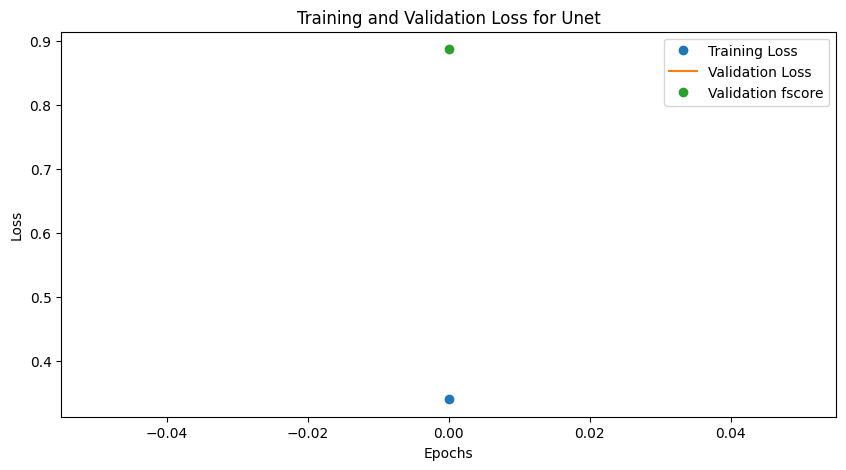

In [ ]:
def model_training(alpha = 0.5, beta = 0.5, gamma = 1, lr = 1e-4):
  ## Loss and metric
  loss_fn = smp.losses.tversky.TverskyLoss(mode ='binary', alpha = alpha, beta = beta, gamma = gamma)
  loss_fn.__name__ = 'Tversky_Loss'
  loss_name = 'Tversky_Loss'
  metrics = [
        F1score_patch(), ]
  metric_name = "custom__fscore"

  # train model for NB_EPOCHS
  for model,model_name in models:
    print(model_name)
    optimizer = torch.optim.Adam([
      dict(params=model.parameters(), lr=lr),])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, mode='min')
    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        device="cuda",
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss_fn,
        metrics=[smp_utils.metrics.Fscore(), F1score_patch(activation='sigmoid')], #metrics
        device="cuda",
        verbose=True,
    )


    max_score = 0
    train_loss_array = []
    validation_loss_array = []
    validation_fscore_array = []


    try:
      for i in range(0, PARAMS["NB_EPOCHS"]):

          print('\nEpoch: {}'.format(i))
          train_logs = train_epoch.run(train_loader)
          valid_logs = valid_epoch.run(valid_loader)

          train_loss_array.append(train_logs[loss_name])
          validation_loss_array.append(valid_logs[loss_name])
          validation_fscore_array.append(valid_logs[metric_name_val])
          print(valid_logs)
          # do something (save model, change lr, etc.)
          if max_score < valid_logs[metric_name_val]:
              max_score = valid_logs[metric_name_val]
              torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))
              print('Model saved!')

          # Update the learning rate scheduler based on the validation loss
          scheduler.step(valid_logs[loss_name])

          # Print the current learning rate
          current_lr = optimizer.param_groups[0]['lr']
          print(f'Current learning rate: {current_lr}')

      epochs = range(0,len(train_loss_array))
      save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Free up memory
        free_memory()

        # Optionally, delete large objects if they are no longer needed
        del model
        del optimizer
        del train_epoch
        del valid_epoch

        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss_array,"o", label='Training Loss')
        plt.plot(epochs, validation_loss_array,  label='Validation Loss')
        plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
        plt.title('Training and Validation Loss for {}'.format(model_name))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Free up memory
        free_memory()





Epoch: 0
valid: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, Tversky_Loss - 0.5301, f1score_patch - 0.0]
An error occurred: 'custom__fscore'


ValueError: ignored

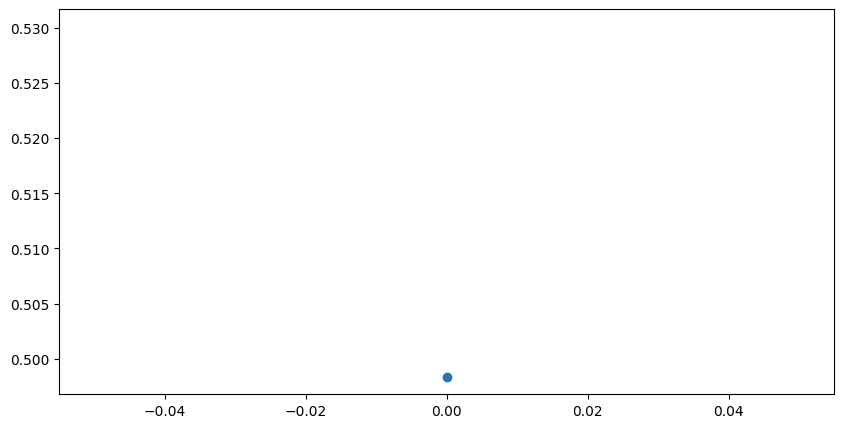

In [ ]:
try:
    for i in range(PARAMS["NB_EPOCHS"]):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_loss_array.append(train_logs[loss_name])

        validation_loss_array.append(valid_logs[loss_name])
        validation_fscore_array.append(valid_logs[metric_name])
        print(valid_logs)
        # do something (save model, change lr, etc.)
        if max_score < valid_logs[metric_name]:
            max_score = valid_logs[metric_name]
            torch.save(model, model_weights_folder + RUN_NAME +'{}.pth'.format(model_name))
            print('Model saved!')

        # Update the learning rate scheduler based on the validation loss
        scheduler.step(valid_logs[loss_name])

        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr}')

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Free up memory
    free_memory()

    # Optionally, delete large objects if they are no longer needed
    del model
    del optimizer
    del train_epoch
    del valid_epoch
    # del train_logs
    # del valid_logs

    # Your existing code for plotting results
    epochs = range(0, len(train_loss_array))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_array, "o", label='Training Loss')
    plt.plot(epochs, validation_loss_array, label='Validation Loss')
    plt.plot(epochs, validation_fscore_array, "o", label='Validation F-score')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Call free_memory() again to ensure all temporary objects are cleared
    free_memory()


## Bayesian optimization

In [32]:
def free_memory():
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Clear system memory
    gc.collect()

In [33]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import gc  # Importing garbage collection module


# Function to initialize a new model
def initialize_model(model_name, encoder_name, encoder_weights, in_channels, classes):
    model = smp.create_model(model_name, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes)
    return model

def model_training(alpha=0.5, beta=0.5, gamma=1, lr=1e-4):
    best_validation_scores = []

    ## Loss and metric
    loss_fn = smp.losses.tversky.TverskyLoss(mode ='binary', alpha = alpha, beta = beta, gamma = gamma)
    loss_fn.__name__ = 'Tversky_Loss'
    loss_name = 'Tversky_Loss'
    metrics = [
          F1score_patch(), ]
    metric_name = "f1score_patch"

    # Loop through the models
    for _, model_name in models:  # Replace with your model names list
        # Reinitialize the model
        model = initialize_model(model_name, PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"], 3, 1)  # Adjust parameters as necessary

        optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=lr)])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, mode='min')

        # # Loss and metric
        # loss_fn = smp.losses.tversky.TverskyLoss(mode='binary', alpha=alpha, beta=beta, gamma=gamma)
        # loss_fn.__name__ = 'Tversky_Loss'
        # loss_name = 'Tversky_Loss'
        # metric_name_val = "f1score_patch"

        # Training and Validation setup
        train_epoch = smp.utils.train.TrainEpoch(
            model,
            loss=loss_fn,
            metrics=metrics,  # Define metrics
            optimizer=optimizer,
            device="cuda",
            verbose=True)

        valid_epoch = smp.utils.train.ValidEpoch(
            model,
            loss=loss_fn,
            metrics=[smp_utils.metrics.Fscore(), F1score_patch(activation='sigmoid')],  # Define metrics
            device="cuda",
            verbose=True)

        max_score = 0
        train_loss_array = []
        validation_loss_array = []
        validation_fscore_array = []

        try:
            for i in range(PARAMS["NB_EPOCHS"]):
                train_logs = train_epoch.run(train_loader)
                valid_logs = valid_epoch.run(valid_loader)

                train_loss_array.append(train_logs[loss_name])
                validation_loss_array.append(valid_logs[loss_name])
                validation_fscore_array.append(valid_logs[metric_name_val])

                if max_score < valid_logs[metric_name_val]:
                    max_score = valid_logs[metric_name_val]
                    torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))

                scheduler.step(valid_logs[loss_name])

            save_results(PARAMS, train_loss_array, validation_loss_array, validation_fscore_array)
            best_validation_scores.append(max(validation_fscore_array))

        except Exception as e:
            print(f"An error occurred: {e}")

        finally:
            # Free up memory
            del model
            del optimizer
            torch.cuda.empty_cache()

    # Optionally, include code for plotting results here

    return max(best_validation_scores)

# Define or import other necessary functions and variables like PARAMS, metrics, train_loader, valid_loader, save_results, etc.


In [36]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import gc  # Importing garbage collection module

# Function to initialize a new model
def initialize_model(model_name, encoder_name, encoder_weights, in_channels, classes):
    model = smp.create_model(model_name, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes)
    return model

def model_training(alpha=0.5, beta=0.5, gamma=1, lr=1e-4):
    best_validation_scores = []

    for _, model_name in models:  # Ensure 'models' is correctly defined
        # Reinitialize the model
        model = initialize_model(model_name, PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"], 3, 1)

        optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=lr)])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, mode='min')

        # Define loss function and metrics
        loss_fn = smp.losses.tversky.TverskyLoss(mode='binary', alpha=alpha, beta=beta, gamma=gamma)
        loss_fn.__name__ = 'Tversky_Loss'
        loss_name = 'Tversky_Loss'
        metrics = [F1score_patch(), ]
        metric_name_val = "f1score_patch"

        # Training and Validation setup
        train_epoch = smp.utils.train.TrainEpoch(model, loss=loss_fn, metrics=metrics, optimizer=optimizer, device="cuda", verbose=True)
        valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss_fn, metrics=[smp_utils.metrics.Fscore(), F1score_patch(activation='sigmoid')], device="cuda", verbose=True)

        max_score = 0
        train_loss_array = []
        validation_loss_array = []
        validation_fscore_array = []

        try:
            for i in range(PARAMS["NB_EPOCHS"]):
                train_logs = train_epoch.run(train_loader)
                valid_logs = valid_epoch.run(valid_loader)

                train_loss_array.append(train_logs[loss_name])
                validation_loss_array.append(valid_logs[loss_name])
                validation_fscore_array.append(valid_logs[metric_name_val])

                if max_score < valid_logs[metric_name_val]:
                    max_score = valid_logs[metric_name_val]
                    torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))

                scheduler.step(valid_logs[loss_name])

            save_results(PARAMS, train_loss_array, validation_loss_array, validation_fscore_array)
            best_validation_scores.append(max(validation_fscore_array))

        except Exception as e:
            print(f"An error occurred: {e}")

        finally:
            # Explicitly free up memory
            del model
            del optimizer
            torch.cuda.empty_cache()
            gc.collect()  # Explicitly calling garbage collection

    return max(best_validation_scores)

# Define or import other necessary functions and variables like PARAMS, metrics, train_loader, valid_loader, save_results, etc.


In [37]:
from bayes_opt import BayesianOptimization
import torch
# models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

def bayesian_optimization(preloaded_points):
    # Define the bounds for each parameter
    pbounds = {
        'alpha': (0.3, 0.7),  # Range for alpha
        'beta': (0.3, 0.7),   # Range for beta
        'gamma': (0.5, 2),    # Range for gamma
        'lr': (1e-5, 1e-3)    # Range for learning rate
    }

    optimizer = BayesianOptimization(
        f=model_training,
        pbounds=pbounds,
        random_state=1,
    )

    # Register preloaded points
    for point in preloaded_points:
        optimizer.register(params=point['params'], target=point['target'])

    # Perform optimization
    optimizer.maximize(
        init_points=2,  # Number of random initial points
        n_iter=10,      # Number of iterations
    )

    # Print the best parameters found
    print("Best Parameters: ", optimizer.max['params'])

# Example usage
# preloaded_points = [
#     {"params": {"alpha": 0.4668, "beta": 0.5881, "gamma": 0.5002 , "lr":  0.0003093}, "target": 0.9366 },
#     {"params": {"alpha": 0.3587, "beta": 0.3369 , "gamma": 0.7794  , "lr":  0.0003521}, "target": 0.9313 },
#     {"params": {"alpha": 0.3031, "beta": 0.3647 , "gamma": 1.564  , "lr":  0.0007671}, "target": 0.9234  },
#     {"params": {"alpha": 0.7  , "beta": 0.7  , "gamma": 0.7313   , "lr":  0.001  }, "target": 0.9442  },
#     {"params": {"alpha": 0.677, "beta": 0.6671  , "gamma": 0.7218 , "lr":  0.0007869}, "target": 0.9465 },
#     # ... add more points if available
# ]
# Run Bayesian Optimization with preloaded points
# bayesian_optimization(preloaded_points)


In [38]:
preloaded_points= []
bayesian_optimization(preloaded_points)


|   iter    |  target   |   alpha   |   beta    |   gamma   |    lr     |
-------------------------------------------------------------------------
valid: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s, Tversky_Loss - 0.6095, fscore - 0.5107, f1score_patch - 0.8667]
test
| 1         | 0.8667    | 0.4668    | 0.5881    | 0.5002    | 0.0003093 |
valid: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s, Tversky_Loss - 0.5125, fscore - 0.2324, f1score_patch - 0.5056]
test
| 2         | 0.5056    | 0.3587    | 0.3369    | 0.7794    | 0.0003521 |
valid: 100%|██████████| 20/20 [00:03<00:00,  6.56it/s, Tversky_Loss - 0.1591, fscore - 0.6732, f1score_patch - 0.7286]
test
| 3         | 0.7286    | 0.3031    | 0.3647    | 1.564     | 0.0007671 |
valid: 100%|██████████| 20/20 [00:02<00:00,  7.20it/s, Tversky_Loss - 0.2055, fscore - 0.7294, f1score_patch - 0.842]
test
| 4         | 0.842     | 0.477     | 0.4654    | 1.322     | 0.0007468 |
train:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it, Tversky

KeyboardInterrupt: ignored

In [ ]:
from bayes_opt import BayesianOptimization
import torch

def bayesian_optimization():
    # Define the bounds for each parameter
    pbounds = {
        'alpha': (0.3, 0.7),  # Example range for alpha
        'beta': (0.3, 0.7),   # Example range for beta
        'gamma': (0.5, 2),    # Example range for gamma
        'lr': (1e-5, 1e-3)    # Example range for learning rate
    }

    optimizer = BayesianOptimization(
        f=model_training,
        pbounds=pbounds,
        random_state=1,
    )

    # Perform optimization
    optimizer.maximize(
        init_points=2,  # Number of random initial points
        n_iter=10,      # Number of iterations
    )

    # Print the best parameters found
    print("Best Parameters: ", optimizer.max['params'])

# Run Bayesian Optimization
bayesian_optimization()

|   iter    |  target   |   alpha   |   beta    |   gamma   |    lr     |
-------------------------------------------------------------------------
valid: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s, Tversky_Loss - 0.3028, fscore - 0.8961, f1score_patch - 0.9207]
test
| 1         | 0.9366    | 0.4668    | 0.5881    | 0.5002    | 0.0003093 |
valid: 100%|██████████| 20/20 [00:02<00:00,  7.35it/s, Tversky_Loss - 0.124, fscore - 0.9051, f1score_patch - 0.9274]
test
| 2         | 0.9313    | 0.3587    | 0.3369    | 0.7794    | 0.0003521 |
valid: 100%|██████████| 20/20 [00:02<00:00,  6.77it/s, Tversky_Loss - 0.01847, fscore - 0.888, f1score_patch - 0.9166]
test
| 3         | 0.9234    | 0.3031    | 0.3647    | 1.564     | 0.0007671 |
valid: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s, Tversky_Loss - 0.1896, fscore - 0.9195, f1score_patch - 0.9378]
test
| 4         | 0.9442    | 0.7       | 0.7       | 0.7313    | 0.001     |
valid: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s, Tversk

# II) Visualization & Submission

In [ ]:
MODEL_NAME = "Unet"
MODEL_PATH = model_weights_folder + f'{RUN_NAME + MODEL_NAME}.pth'
# MODEL_PATH = model_weights_folder + 'test_best_model_Unet.pth'
DEVICE ='cuda'

test_model = torch.load(MODEL_PATH)

foreground_threshold = 0.5  # Threshold for determining foreground vs background

FileNotFoundError: ignored

In [ ]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


### Visualization

In [ ]:
# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
activate_threshold = True
img_nbr = 4
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_cpu = pr_gt.cpu().numpy().squeeze()
            if activate_threshold:
              pr_gt_cpu[pr_gt_cpu >= foreground_threshold] = 1
              pr_gt_cpu[pr_gt_cpu < foreground_threshold] = 0

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


In [ ]:
# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
activate_threshold = True
img_nbr = 50
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_cpu = pr_gt.cpu().numpy().squeeze()
            if activate_threshold:
              pr_gt_cpu[pr_gt_cpu >= foreground_threshold] = 1
              pr_gt_cpu[pr_gt_cpu < foreground_threshold] = 0

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


Output hidden; open in https://colab.research.google.com to view.

### .csv File

In [ ]:
### with average of multiple predictions
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)

# Parameters for saving images
output_folder = submission_folder + 'eval_imgs/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        n, c, h, w = input_tensor.size()
        sum = torch.zeros((n, 1, h, w), device='cuda')
        for i in range(4):
          img_rot = torch.rot90(input_tensor, i%4, [2, 3])
          prediction = test_model(img_rot)
          prediction = torch.rot90(prediction, 4-(i%4), [2, 3]) #rotation back
          sum += prediction

        pred = sum / 4
        pred_np = pred.detach().cpu().numpy()[0, 0]
        pred_np = 1 / (1 + np.exp(-pred_np))
        pred_voting = (pred_np > 0.5).astype(float)*255

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'

        cv2.imwrite(os.path.join(output_folder, filename), pred_voting)

./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_4/test_4.png
./data/test_set_images/test_5/test_5.png
./data/test_set_images/test_6/test_6.png
./data/test_set_images/test_7/test_7.png
./data/test_set_images/test_8/test_8.png
./data/test_set_images/test_9/test_9.png
./data/test_set_images/test_10/test_10.png
./data/test_set_images/test_11/test_11.png
./data/test_set_images/test_12/test_12.png
./data/test_set_images/test_13/test_13.png
./data/test_set_images/test_14/test_14.png
./data/test_set_images/test_15/test_15.png
./data/test_set_images/test_16/test_16.png
./data/test_set_images/test_17/test_17.png
./data/test_set_images/test_18/test_18.png
./data/test_set_images/test_19/test_19.png
./data/test_set_images/test_20/test_20.png
./data/test_set_images/test_21/test_21.png
./data/test_set_images/test_22/test_22.png
./data/test_set_images/test_23/test_23.png
./data/test_set_images/test_2

In [ ]:
submission_filename = submission_folder + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = submission_folder + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


In [ ]:
submission_filename

'./submissions/submission_vic_aug6/test_submission.csv'

# Second DL network (cascade)

In [ ]:
PARAMS = {
  'MODELS' : ["Unet"], # Available : "Unet","DeepLabV3","FPN", "UnetPlusPlus"
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 25,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : True, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}


In [ ]:
# Default parameters for various parts
foreground_threshold = 0.5  # Threshold for determining foreground vs background
lr = 1e-4

# Loss and metric type
loss_type = "dice" # Possible: ["dice", "tversky", "custom"]
metric_type = "fscore" # custom: ["custom", "fscore"]

## Dataset class

In [ ]:
class Dataset2(BaseDataset):
  CLASSES = ['road', 'unlabelled']
  def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None, plot = False):
      self.ids = os.listdir(images_dir)
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

      # convert str names to class values on masks
      if classes is not None:
          self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

      self.augmentation = augmentation
      self.preprocessing = preprocessing
      # self.preprocessing = None
      self.plot = plot

  def __getitem__(self, i):

      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = cv2.resize(image, (416, 416))
      # initialize mask as None
      mask = None

      if self.masks_fps == None:
        print(self.images_fps[i])
        if self.augmentation:
          sample = self.augmentation(image=image)
          image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        return self.images_fps[i], image

      else:
        mask = cv2.imread(self.masks_fps[i], 0)
        # mask = cv2.resize(mask, (416, 416))
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
        return image, mask

  def __len__(self):
      return len(self.ids)

## Data production from previous model

In [ ]:
MODEL_NAME = "Unet"
# MODEL_PATH = model_weights_folder + f'{RUN_NAME + MODEL_NAME}.pth'
MODEL_PATH = model_weights_folder + 'vic_aug3Unet.pth'
DEVICE ='cuda'

test_model = torch.load(MODEL_PATH)

foreground_threshold = 0.5  # Threshold for determining foreground vs background

In [ ]:
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented_vic2/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented_vic2/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation_vic2/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation_vic2/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented_vic2/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented_vic2/masks/"
PATH_VAL_IMG = "./data/data_validation_vic2/images/"
PATH_VAL_MASK = "./data/data_validation_vic2/masks/"

#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
eval_train_dataset = Dataset2(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset2(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
eval_train_loader = DataLoader(eval_train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

## Yo


In [ ]:
submission_folder

'./submissions/submission_vic_aug3/'

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)

# Parameters for saving images
output_folder_images = "./data/train_dl2/img/"
output_folder_masks = "./data/train_dl2/mask/"
os.makedirs(output_folder_images, exist_ok=True)
os.makedirs(output_folder_masks, exist_ok=True)

# Iterate over the DataLoader
for i, (image, mask) in enumerate(eval_train_dataset):
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image and mask
        image_num = i + 1  # Assuming 'i' starts from 0
        image_filename = f"img_{image_num:03d}.png"
        mask_filename = f"mask_{image_num:03d}.png"

        prediction_pil_resized.save(os.path.join(output_folder_images, image_filename))
        to_pil_image(mask).resize((608, 608), Image.NEAREST).save(os.path.join(output_folder_masks, mask_filename))


TypeError: ignored